# Analyze the baseline model by solving the differential equations
Integrates the differential equations and solves for the fixed points and stability. 

This script produces the bifurcation diagrams (Fig 2) in main text,  and Fig S1 of the supplement. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.lines as mlines
import copy

# import functions in my_functions
import ipynb.fs.defs.my_functions as myfun

### Define the ODE system

In [2]:
def odeSys(var, t, para):
    """
    Define the system of ordinary differential equations 
    var = 2-column matrix, where the two columns are xi and xs, respectively. xi = proportion of individual learners favor option X, xs = proportion of social learners favor option X. 
    para = dictionary that stores the parameters of the system. 
    t = time array. 
    """
    xi, xs = var
    
    # compute proportion of total favoring option X. 
    x = (1-para["s"])*xi + para["s"]*xs
    
    # define the derivative dx_i/dt according to ODE
    dxi_dt = para["m"]*(1 - xi) - (1 - para["m"])*xi
    
    # define  transition rates of social learners 
    T_in = myfun.f(x, para["alpha"]) # transitioning from option Y into X 
    T_out = myfun.f((1-x), para["alpha"])  # transitioning from X to Y. 
    
    # define derivative dx_s/dt according to ODE. 
    dxs_dt = T_in*(1-xs) - T_out*(xs)
    
    return [dxi_dt, dxs_dt]

### Run ODE system over time

Text(0.5, 0, 'time')

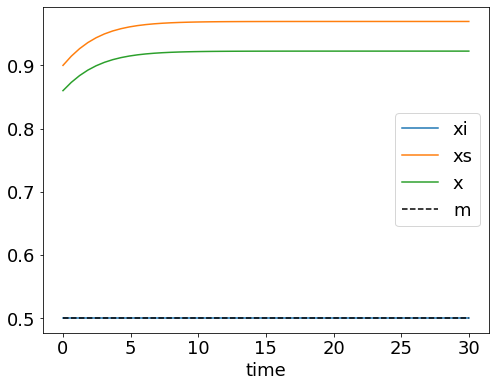

In [3]:
var0 = [0.5, 0.9] # initial condition for [x_i, x_s]
para = {"s": 0.9, "m": 0.5, "alpha": 1.5}  # parameters of system. 
t = np.linspace(0, 30, 50) #  time 

var = odeint(odeSys, var0, t, args = (para,))  # run ode system 

# plot results 
xi = var[:,0]
xs = var[:, 1]
x = (1-para["s"])*xi + (para["s"])*xs

plt.figure(figsize = (8, 6))
plt.plot(t, xi) 
plt.plot(t, xs)
plt.plot(t, x )
plt.plot(t, para["m"]*np.ones(np.shape(t)), "k--")
plt.legend(["xi", "xs", "x", "m"])
plt.xlabel("time")


### Solve for fixed points and stability
Fixed points are where both derivatives, dx_i/dt = dx_s/dt = 0. 

In [11]:
'''
Because it is obvious that xi = m is the only fixed point of the u equation, and it is stable, 
we focus on solving the fixed point of the xs equation and look at its stability. If the xs fixed point is stable, the system is stable, and if the xs fixed point is unstable, then the system is unstable. 
'''

def rhs_s_eq(xs, para):
    """
    Compute the right hand side of the x_s equation at the point x_i = m
    """
        
    x = (1 - para["s"])*para["m"]+ para["s"]*xs
    
    T_in = myfun.f(x, para["alpha"]) # transition rate from Y to X
    T_out = myfun.f(1.-x, para["alpha"]) # transition rate from X to Y 
    
    rhs = T_in*(1.-xs) - T_out*xs
    
    return rhs

def d_rhs_s_eq(xs, para, delta_xs = 0.05): 
    """
    Compute the derivate of the righ hand side of the xs equation with respect to xs, using central differencing. This will be used to compute stability of fixed points. 
    """
    
    rhs_right = rhs_s_eq(xs + delta_xs, para)
    rhs_left = rhs_s_eq(xs - delta_xs, para)
    d_rhs = (rhs_right - rhs_left)/(2*delta_xs)
    
    return d_rhs

def get_branch(slist, xs0, para):
    """
    Get the fixed point for xs for one branch of the bifurcation diagram. 
    slist = a list of s values to compute the solution for 
    xs0 = initial value of xs
    para = parameters of the system. 
    """
    
    xs_sol = [] # List to store solution for fixed point of xs. 
    stab = [] # List to store the stability of the fixed points
    sout = [] # List to store the s values when in to the computation. 
    for s in slist: 
        para["s"] = s
        # solve for the when the rhs of xs equation is 0. 
        sol, blah, flag, blah2 = fsolve(rhs_s_eq, xs0, args=(para, ), xtol = 1e-8, full_output=1)

        # check if fsolve converged. 
        if flag == 1: 
            xs0 = sol[0] # update initial condition for numerical continuation
            xs_sol.append(sol[0]) # store solution 
            
            # determine stability
            drhs_dxs = d_rhs_s_eq(sol[0], para)
            
            if drhs_dxs <0: # if derivative negative, then fixed point stable. 
                stab1 = 1
            elif drhs_dxs > 0: # if derivative positive, then fixed point unstable. 
                stab1 = 0
            else:  #if derivative = 0, stablility un-derterimned. 
                stab1 = np.nan
            stab.append(stab1)
            
            sout.append(s) # store s values. 
            
        else: 
            break 
    return np.asarray(xs_sol), np.asarray(stab), np.asarray(sout)

def plotBranch(xs_sol, stab, sout, para): 
    """
    Plot 1 branch of the bifurcation diagram. 
    """
    # get index of the stable and unstable fixed points 
    stabIdx = (stab==1)
    unstabIdx = (stab==0)
      
    # find fixed points of x based on solution to xs. 
    xsol = (1 - sout)*para["m"] + sout*xs_sol

    plt.plot(sout[stabIdx], xsol[stabIdx], "b-")
    plt.plot(sout[unstabIdx], xsol[unstabIdx], "b--")

def numerical_cont(slist, para, xs0List):
    """
    Numerical continuation running multiple bifurcation branches with different starting conditions
    """
    for xs0 in xs0List:
        xs_sol, stab, sout = get_branch(slist, xs0, para)
        plotBranch(xs_sol, stab, sout, para)
        
        
  

##  Solve for the point of bifurcation

In [14]:
def get_rc(mlist, slist, alphalist):
    """
    Find the critical bifurcation point of the bifurcation diagrams. 
    mlist = a list of (a few) m values
    slist = a list of s values. 
    alphalist = a list of alpha values. (to be plotted on x-axis)
    
    """

    sstarlist = []
    # run 1 branch from v = 0, the last point should be where the stable and unstable meets. 
    # Note this only applies to m >= 0.5. 
    v0 = 0
    for m in mlist: 
        sstar = []
        for alpha in alphalist: 
            para = {"r": np.nan, "m": m, "alpha": alpha}
            # the value r here isn't useful... it gets over written by the next line. 
    
            vsol, stab, sout = get_branch(slist, v0, para)
            sstar.append(copy.deepcopy(sout[-1]))
        sstarlist.append(sstar)
    return sstartlist 

"""
Numerically solve for the bifurcation point 
"""
slist = np.linspace(1, 0.5, 2000)
alphalist = np.linspace(1.01, 2, 40)

mlist = [0.501, 0.7, 0.9]
sstarlist = []

# run 1 branch from v = 0, the last point should be where the stable and unstable meets. 
# Note this only applies to m >= 0.5. 

v0 = 0
for m in mlist: 
    sstar = []
    for alpha in alphalist: 
        para = {"r": np.nan, "m": m, "alpha": alpha}
    
        vsol, stab, sout = get_branch(slist, v0, para)
        sstar.append(copy.deepcopy(sout[-1]))
    sstarlist.append(sstar)

In [17]:
"""
Bifurcation with parameter m. 
"""

def get_branch_m(mlist, v0, para):
    """
    Get 1 branch of the fixed points, with m as teh varying parameter
    """
    vsol = []
    stab = []
    mout = []
    for m in mlist: 
        para["m"] = m
        sol, blah, flag, blah2 = fsolve(rhs_s_eq, v0, args=(para, ), xtol = 1e-6, full_output=1) # this solves for fixed point of v.
     
        if (flag == 1)  & (sol[0] >= -0.05 ) & (sol[0]<=1.05) : 
            v0 = sol[0] # update initial condition for continuation
            vsol.append(sol[0]) # store solution 
            
            # stability
            dRhs = d_rhs_s_eq(sol[0], para)
         
            if dRhs<0:
                stab1 = 1
            elif dRhs > 0:
                stab1 = 0
            else: 
                stab1 = np.nan
            stab.append(stab1)
            
            mout.append(m)
            
        else: 
            break 
    return np.asarray(vsol), np.asarray(stab), np.asarray(mout)


"""
Plot 1 branch of the bifurcation diagram, with m as the varying parameter
"""
def plotBranch_m(xs_sol, stab, mout, para): 
    stabIdx = (stab==1)
    unstabIdx = (stab==0)
      
    # translate v to x. 
    xsol = (1-para["s"])*mout + para["s"]*xs_sol
    
    plt.plot(mout[stabIdx], xsol[stabIdx], "b-")
    plt.plot(mout[unstabIdx], xsol[unstabIdx], "b--")

"""
Numerical continuation running multiple starting conditions, with m as the varliable
"""
def numerical_cont_m(mlist, para, v0List):
    for v0 in v0List:
        xs_sol, stab, mout = get_branch_m(mlist, v0, para)
        plotBranch_m(xs_sol, stab, mout, para)


### Generate Fig 2 results

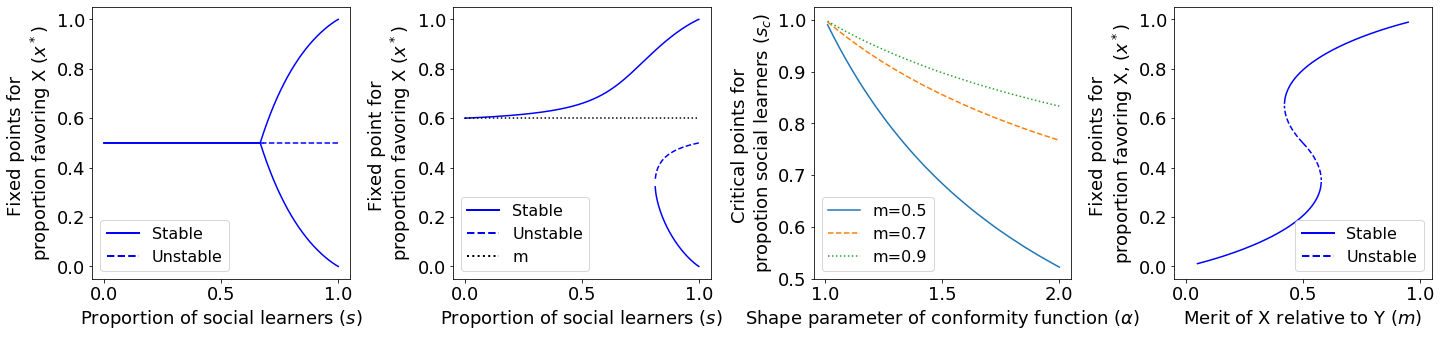

In [18]:

"""
This is code for plotting the result from the core model by solving for fixed points and stability for the dynamical system.
"""
plt.figure(figsize = (24, 5))

"""
(A) Bifurcation diagram of x vs. r; Equal merit 
"""
plt.subplot(1, 4, 1)
para = {"s": np.nan, "m": 0.5, "alpha": 1.5}
slist = np.linspace(1, 0, 1000) # the direction of the plot is right to left, for continuation

xs0_List = [0, 0.5, 1]

numerical_cont(slist, para, xs0_List)

plt.xlabel("Proportion of social learners ($s$)")
plt.ylabel("Fixed points for \nproportion favoring X ($x^*$)")

# legend
blueLine = mlines.Line2D([], [],color='b', marker="None", linestyle='-',
                          linewidth=2, label='Stable')
blueDashLine = mlines.Line2D([], [],color='b', marker="None", linestyle='--',
                          linewidth=2, label= 'Unstable')
plt.legend(handles = [blueLine, blueDashLine], loc = 3, prop={'size': 16})
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])


"""
(B) Bifurcation diagram of x vs. r; Unequal merit 
"""
plt.subplot(1, 4, 2)
para = {"r": np.nan, "m": 0.6, "alpha": 1.5}
slist = np.linspace(1, 0, 1000)
xs0_List = [0, 0.5, 1]
numerical_cont(slist, para, xs0_List)

plt.plot([0, 1], [para["m"], para["m"]], "k:")

# legends 
blueLine = mlines.Line2D([], [],color='b', marker="None", linestyle='-',
                          linewidth=2, label='Stable')
blueDashLine = mlines.Line2D([], [],color='b', marker="None", linestyle='--',
                          linewidth=2, label= 'Unstable')
blackDotLine = mlines.Line2D([], [],color='k', marker="None", linestyle=':',
                          linewidth=2, label= 'm')

plt.legend(handles = [blueLine, blueDashLine, blackDotLine], loc = 3, prop={'size': 16})

plt.xlabel("Proportion of social learners ($s$)")
plt.ylabel("Fixed point for \nproportion favoring X ($x^*$)")
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])


"""
(C) Critical r. 
"""

plt.subplot(1, 4, 3)
plt.plot(alphalist, sstarlist[0], "-")
plt.plot(alphalist, sstarlist[1], "--")
plt.plot(alphalist, sstarlist[2], ":")
plt.xlim([0.95, 2.05])
plt.xlabel(r"Shape parameter of conformity function ($\alpha$)")
plt.ylabel("Critical points for \n" + r"propotion social learners ($s_c$)")
plt.legend(["m=0.5", "m=0.7", "m=0.9"], loc = 3, prop={'size': 16})
plt.ylim([0.5, 1.025])


"""
(D) Bifurcation diagram with m on the x-axis 
"""
plt.subplot(1, 4, 4)


mlist = np.linspace(0.05, 0.95, 500)
       
para = {"s": 0.8, "m": 0.7, "alpha": 1.5}
numerical_cont_m(mlist, para, [0.02])
numerical_cont_m(np.flip(mlist), para, [0.95])
numerical_cont_m(np.linspace(0.5, 0.6, 1000), para, [0.5])
numerical_cont_m(np.linspace(0.5, 0.4, 1000), para, [0.5])

plt.xlabel("Merit of X relative to Y ($m$)")
plt.ylabel("Fixed points for \nproportion favoring X, ($x^*$)")
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

# legend
blueLine = mlines.Line2D([], [],color='b', marker="None", linestyle='-',
                          linewidth=2, label='Stable')
blueDashLine = mlines.Line2D([], [],color='b', marker="None", linestyle='--',
                          linewidth=2, label= 'Unstable')
plt.legend(handles = [blueLine, blueDashLine], loc = 4, prop={'size': 16})
plt.subplots_adjust(wspace=0.4)

plt.savefig('fig1.pdf', dpi = 700)



### Composite figure for solution with  alpha < 1

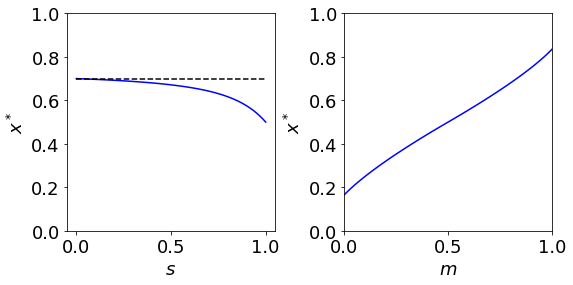

In [19]:


plt.figure(figsize = (8.7, 4))

"""
(A) Bifurcation with r 
"""
plt.subplot(1, 2, 1)
para = {"s": np.nan, "m": 0.7, "alpha": 0.8}
slist = np.linspace(1, 0, 100) # the direction of the plot is right to left, for continuation

xs0List = [ 0.5]
numerical_cont(slist, para, xs0List)
plt.plot([0, 1], [0.7, 0.7], "k--")
plt.xlabel(r"$s$")
plt.ylabel(r"$x^*$")
plt.ylim([0, 1])


"""
(B) Bifurcation with with m 
"""
plt.subplot(1, 2, 2)


mlist = np.linspace(0.0, 1, 100)
       
para = {"s": 0.8, "m": 0.7, "alpha": 0.8}
numerical_cont_m(mlist, para, [0.5])
plt.xlabel("$m$")
plt.ylabel("$x^*$")
plt.ylim([0, 1])
plt.xlim([0, 1])


plt.subplots_adjust(wspace=0.33)


